Objective: We will create a Linear Regression model to predict revenue and make recommendations on how to create a successful movie.

In [1]:
# Import relevant libraries
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import re

## Function Definitions


In [2]:
## Function to obtain genre names as a list 
def get_genre_name(x):
    x = x.replace("'",'"')
    x = json.loads(x)
    
    genres = []
    for genre in x:
        genres.append(genre['name'])
    return genres

In [3]:
## Function to evaluate OLS regression residuals
def evaluate_ols(result,X_train_df,y_train,show_summary=True):
    """Plots a Q-Q plot and residual plot for a statsmodels OLS regression"""
    try:
        display(result.summary())
    except:
        pass
    
    ## save residuals from result
    y_pred = result.predict(X_train_df)
    resid = y_train - y_pred
    
    fig, axes = plt.subplots(ncols=2, figsize=(12,5))
    
    ## Normality
    sm.graphics.qqplot(resid, line='45', fit=True, ax=axes[0]);
    
    ## Homoscedasticity
    ax = axes[1]
    ax.scatter(y_pred, resid, edgecolor='white',lw=1)
    ax.axhline(0,zorder=0)
    ax.set(ylabel='Residuals',xlabel='Predicted Value');
    plt.tight_layout()

In [4]:
## Function to extract production company names
def get_prod_company_names(x):
    if x=='[]':
        return ["MISSING"]
    
    exp= r"\'name\'\:.?\'(\w*.*?)\'"
    companies = re.findall(exp, x)
    return companies

## Load and Inspect Data

In [5]:
df = pd.read_csv('Data/final_tmdb_data_combined.csv.gz',lineterminator='\n')

In [6]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60130 entries, 0 to 60129
Data columns (total 26 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   imdb_id                60130 non-null  object 
 1   adult                  60130 non-null  float64
 2   backdrop_path          36994 non-null  object 
 3   belongs_to_collection  3738 non-null   object 
 4   budget                 60130 non-null  float64
 5   genres                 60130 non-null  object 
 6   homepage               14776 non-null  object 
 7   id                     60130 non-null  float64
 8   original_language      60130 non-null  object 
 9   original_title         60130 non-null  object 
 10  overview               58761 non-null  object 
 11  popularity             60130 non-null  float64
 12  poster_path            54382 non-null  object 
 13  production_companies   60130 non-null  object 
 14  production_countries   60130 non-null  object 
 15  re

,imdb_id,adult,backdrop_path,belongs_to_collection,budget,genres,homepage,id,original_language,original_title,...,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,certification
0,tt0113026,0.0,/vMFs7nw6P0bIV1jDsQpxAieAVnH.jpg,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",NaN,62127.0,en,The Fantasticks,...,0.0,86.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,Try to remember the first time magic happened,The Fantasticks,0.0,5.4,21.0,NaN
1,tt0113092,0.0,NaN,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",NaN,110977.0,en,For the Cause,...,0.0,100.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,The ultimate showdown on a forbidden planet.,For the Cause,0.0,4.4,7.0,NaN
2,tt0116391,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",NaN,442869.0,hi,Gang,...,0.0,152.0,"[{'english_name': 'Hindi', 'iso_639_1': 'hi', ...",Released,NaN,Gang,0.0,0.0,0.0,NaN
3,tt0118694,0.0,/n4GJFGzsc7NinI1VeGDXIcQjtU2.jpg,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",http://www.wkw-inthemoodforlove.com/,843.0,cn,花樣年華,...,12854953.0,99.0,"[{'english_name': 'Cantonese', 'iso_639_1': 'c...",Released,"Feel the heat, keep the feeling burning, let t...",In the Mood for Love,0.0,8.1,1868.0,PG
4,tt0118852,0.0,NaN,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",NaN,49511.0,en,Chinese Coffee,...,0.0,99.0,"[{'english_name': 'English', 'iso_639_1': 'en'...",Released,There's a fine line between friendship and bet...,Chinese Coffee,0.0,6.9,46.0,R


In [7]:
## remove ids that are 0 and reset index
df = df.loc[df['imdb_id']!='0']
df = df.reset_index(drop=True)

## Feature Engineering

In [8]:
## Exclude columns unlikely relevant to revenue
drop_cols = ['backdrop_path','original_title','overview',
            'poster_path','tagline','id','homepage',
            'production_countries','video','spoken_languages',
            'original_language']
df = df.drop(columns=drop_cols)
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count,certification
0,tt0113026,0.0,NaN,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,The Fantasticks,5.4,21.0,NaN
1,tt0113092,0.0,NaN,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,For the Cause,4.4,7.0,NaN
2,tt0116391,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Released,Gang,0.0,0.0,NaN
3,tt0118694,0.0,NaN,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,In the Mood for Love,8.1,1868.0,PG
4,tt0118852,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}]",4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,Chinese Coffee,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,NaN,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,Heiko's World,0.0,0.0,NaN
60126,tt9896876,0.0,NaN,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,India Sweets and Spices,6.0,2.0,PG-13
60127,tt9898844,0.0,NaN,0.0,"[{'id': 27, 'name': 'Horror'}]",421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,The Hunting,4.9,20.0,NaN
60128,tt9900940,0.0,NaN,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,The Scrapper,6.0,2.0,NaN


In [9]:
## Use .notna() to convert 'belongs_to_collection' into Boolean feature
df['belongs_to_collection'] = df['belongs_to_collection'].notna()
df['belongs_to_collection'].value_counts()
df

,imdb_id,adult,belongs_to_collection,budget,genres,popularity,production_companies,release_date,revenue,runtime,status,title,vote_average,vote_count,certification
0,tt0113026,0.0,False,10000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10402, '...",2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,The Fantasticks,5.4,21.0,NaN
1,tt0113092,0.0,False,0.0,"[{'id': 878, 'name': 'Science Fiction'}]",1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,For the Cause,4.4,7.0,NaN
2,tt0116391,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 28, 'name...",1.341,[],2000-04-14,0.0,152.0,Released,Gang,0.0,0.0,NaN
3,tt0118694,0.0,False,150000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,In the Mood for Love,8.1,1868.0,PG
4,tt0118852,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}]",4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,Chinese Coffee,6.9,46.0,R
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,Heiko's World,0.0,0.0,NaN
60126,tt9896876,0.0,False,0.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,India Sweets and Spices,6.0,2.0,PG-13
60127,tt9898844,0.0,False,0.0,"[{'id': 27, 'name': 'Horror'}]",421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,The Hunting,4.9,20.0,NaN
60128,tt9900940,0.0,False,0.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,The Scrapper,6.0,2.0,NaN


In [10]:
# Explode genres column using get_genre_name function
df['genres_list'] = df['genres'].apply(get_genre_name)
df_explode = df.explode('genres_list')

In [11]:
## save unique genres
unique_genres = df_explode['genres_list'].dropna().unique()

In [12]:
## Manually One-Hot-Encode Genres
for genre in unique_genres:
    df[f"Genre_{genre}"] = df['genres'].str.contains(genre,regex=False)  

In [13]:
## Drop original genre cols
df = df.drop(columns=['genres','genres_list'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,release_date,revenue,runtime,status,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",2000-09-22,0.0,86.0,Released,...,False,False,False,False,False,False,False,False,False,False
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",2000-11-15,0.0,100.0,Released,...,False,False,False,False,False,False,False,False,False,False
2,tt0116391,0.0,False,0.0,1.341,[],2000-04-14,0.0,152.0,Released,...,False,False,False,False,False,False,False,False,False,False
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",2000-09-29,12854953.0,99.0,Released,...,False,False,False,False,False,False,False,False,False,False
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",2000-09-02,0.0,99.0,Released,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",2021-09-08,0.0,118.0,Released,...,False,False,False,False,False,False,False,False,False,False
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",2021-11-19,0.0,101.0,Released,...,False,False,False,False,False,False,False,False,False,False
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",2022-01-21,0.0,91.0,Released,...,False,True,False,False,False,False,False,False,False,False
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",2021-12-07,0.0,87.0,Released,...,False,False,True,False,False,False,False,False,False,False


In [14]:
# Clean MPAA rating feature
df['certification'] = df['certification'].str.strip()

repl_cert = {'UR':'NR',
             'Not Rated':'NR',
             'Unrated':'NR',
             '-':'NR',
             '10':np.nan,
             'ScreamFest Horror Film Festival':'NR'}
df['certification'] = df['certification'].replace(repl_cert)
df['certification'] = df['certification'].fillna('NR')
df['certification'].value_counts(dropna=False)

NR       48777
R         6098
PG-13     3225
PG        1432
G          442
NC-17      156
Name: certification, dtype: int64

In [15]:
# Splitting release_date into 3 columns
new_cols = ['year','month','day']
df[new_cols] = df['release_date'].str.split('-',expand=True)
df[new_cols] = df[new_cols].astype(float)

## drop original feature
df = df.drop(columns=['release_date'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,status,title,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,Released,The Fantasticks,...,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,Released,For the Cause,...,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Released,Gang,...,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,Released,In the Mood for Love,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Released,Chinese Coffee,...,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Released,Heiko's World,...,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,Released,India Sweets and Spices,...,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,Released,The Hunting,...,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,Released,The Scrapper,...,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [16]:
## Filter to keep only Released movies
df = df.loc[ df['status'] == 'Released']
df = df.drop(columns=['status'])
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
0,tt0113026,0.0,False,10000000.0,2.491,"[{'id': 51207, 'logo_path': None, 'name': 'Sul...",0.0,86.0,The Fantasticks,5.4,...,False,False,False,False,False,False,False,2000.0,9.0,22.0
1,tt0113092,0.0,False,0.0,1.974,"[{'id': 7405, 'logo_path': '/rfnws0uY8rsNAsrLb...",0.0,100.0,For the Cause,4.4,...,False,False,False,False,False,False,False,2000.0,11.0,15.0
2,tt0116391,0.0,False,0.0,1.341,[],0.0,152.0,Gang,0.0,...,False,False,False,False,False,False,False,2000.0,4.0,14.0
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
4,tt0118852,0.0,False,0.0,4.889,"[{'id': 67930, 'logo_path': None, 'name': 'Cha...",0.0,99.0,Chinese Coffee,6.9,...,False,False,False,False,False,False,False,2000.0,9.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60125,tt9895024,0.0,False,0.0,0.840,"[{'id': 154995, 'logo_path': None, 'name': 'AS...",0.0,118.0,Heiko's World,0.0,...,False,False,False,False,False,False,False,2021.0,9.0,8.0
60126,tt9896876,0.0,False,0.0,3.665,"[{'id': 737, 'logo_path': '/dK1GZ1u4our8sJW0St...",0.0,101.0,India Sweets and Spices,6.0,...,False,False,False,False,False,False,False,2021.0,11.0,19.0
60127,tt9898844,0.0,False,0.0,421.143,"[{'id': 160303, 'logo_path': None, 'name': 'Mo...",0.0,91.0,The Hunting,4.9,...,False,False,False,False,False,False,False,2022.0,1.0,21.0
60128,tt9900940,0.0,False,0.0,3.416,"[{'id': 91999, 'logo_path': None, 'name': 'Luc...",0.0,87.0,The Scrapper,6.0,...,False,False,False,False,False,False,False,2021.0,12.0,7.0


In [17]:
## Filter out movies with no financial data
df = df.loc[(df['budget'] >0 ) & (df['revenue']>0)]
df

,imdb_id,adult,belongs_to_collection,budget,popularity,production_companies,revenue,runtime,title,vote_average,...,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary,year,month,day
3,tt0118694,0.0,False,150000.0,22.411,"[{'id': 539, 'logo_path': None, 'name': 'Block...",12854953.0,99.0,In the Mood for Love,8.1,...,False,False,False,False,False,False,False,2000.0,9.0,29.0
10,tt0120467,0.0,False,120000.0,5.300,"[{'id': 102045, 'logo_path': None, 'name': 'Ch...",14904.0,87.0,Vulgar,5.5,...,False,False,False,False,False,False,False,2002.0,4.0,26.0
12,tt0120630,0.0,True,45000000.0,51.339,"[{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...",224834564.0,84.0,Chicken Run,6.7,...,False,True,False,False,False,False,False,2000.0,6.0,21.0
15,tt0120753,0.0,False,8000000.0,8.371,"[{'id': 1490, 'logo_path': None, 'name': 'Kint...",105983.0,122.0,The Million Dollar Hotel,5.9,...,False,False,False,False,False,False,False,2000.0,2.0,9.0
16,tt0120755,0.0,True,125000000.0,26.731,"[{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...",546388105.0,123.0,Mission: Impossible II,6.1,...,False,False,False,False,False,False,False,2000.0,5.0,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60053,tt9639470,0.0,False,43000000.0,157.932,"[{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...",22957625.0,117.0,Last Night in Soho,7.5,...,False,False,True,False,False,False,False,2021.0,10.0,21.0
60058,tt9664108,0.0,False,20000000.0,91.077,"[{'id': 148185, 'logo_path': None, 'name': 'No...",4284903.0,108.0,Voyagers,6.1,...,False,False,False,False,False,False,False,2021.0,4.0,8.0
60094,tt9784798,0.0,False,26000000.0,16.946,"[{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...",6416063.0,126.0,Judas and the Black Messiah,7.4,...,True,False,False,False,False,False,False,2021.0,2.0,12.0
60106,tt9844322,0.0,False,17516235.0,8.904,"[{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...",19002036.0,120.0,Kaamelott: The First Chapter,6.9,...,False,False,False,False,False,False,False,2021.0,7.0,21.0


In [18]:
## Production company
df['production_companies']

3        [{'id': 539, 'logo_path': None, 'name': 'Block...
10       [{'id': 102045, 'logo_path': None, 'name': 'Ch...
12       [{'id': 521, 'logo_path': '/kP7t6RwGz2AvvTkvnI...
15       [{'id': 1490, 'logo_path': None, 'name': 'Kint...
16       [{'id': 4, 'logo_path': '/gz66EfNoYPqHTYI4q9UE...
                               ...                        
60053    [{'id': 10146, 'logo_path': '/xnFIOeq5cKw09kCW...
60058    [{'id': 148185, 'logo_path': None, 'name': 'No...
60094    [{'id': 79426, 'logo_path': '/8aEC7xem9YwHNCDo...
60106    [{'id': 2902, 'logo_path': '/nSPZ1BNASeC2dxJKB...
60107    [{'id': 333, 'logo_path': '/5xUJfzPZ8jWJUDzYtI...
Name: production_companies, Length: 5090, dtype: object

In [19]:
## getting longest string to check for multiple companies
idxmax = df['production_companies'].apply(len).idxmax()
test = df.loc[idxmax, 'production_companies']
test

"[{'id': 53671, 'logo_path': None, 'name': 'Lantia Cinema & Audiovisivi', 'origin_country': ''}, {'id': 8, 'logo_path': '/78ilmDNTpdCfsakrsLqmAUkFTrO.png', 'name': 'Fine Line Features', 'origin_country': ''}, {'id': 76, 'logo_path': '/nebkQYtQKhZyHJfh5v0oGpNbPzu.png', 'name': 'Zentropa Entertainments', 'origin_country': 'DK'}, {'id': 119, 'logo_path': '/1di2gITGUZr730AMuMKiCrP90Vl.png', 'name': 'DR', 'origin_country': 'DK'}, {'id': 157, 'logo_path': None, 'name': 'SVT Drama', 'origin_country': ''}, {'id': 201, 'logo_path': '/6UIpEURdjnmcJPwgTDRzVRuwADr.png', 'name': 'ARTE', 'origin_country': 'FR'}, {'id': 321, 'logo_path': '/pfp6VWF3tYfOHHVRHpYe2iGcYrf.png', 'name': 'Memfis Film', 'origin_country': 'SE'}, {'id': 591, 'logo_path': '/q5I5RDwMEiqoNmfaJgd2LraEOJY.png', 'name': 'France 3 Cinéma', 'origin_country': 'FR'}, {'id': 2996, 'logo_path': None, 'name': 'Angel films', 'origin_country': ''}, {'id': 5975, 'logo_path': '/vvjgoKygWWYZvYyidT3RmOCq5If.png', 'name': 'YLE', 'origin_country':

In [20]:
get_prod_company_names(test)

['Lantia Cinema & Audiovisivi',
 'Fine Line Features',
 'Zentropa Entertainments',
 'DR',
 'SVT Drama',
 'ARTE',
 'Memfis Film',
 'France 3 Cinéma',
 'Angel films',
 'YLE',
 'Blind Spot Pictures',
 'VPRO',
 'Liberator Productions',
 'Íslenska kvikmyndasamsteypan',
 'Pain Unlimited GmbH Filmproduktion',
 'Trust Film Svenska',
 'Cinematograph A/S',
 'What Else? B.V',
 'Filmek A/S',
 'Film4 Productions',
 'Canal+',
 'ARTE France Cinéma',
 'Film i Väst',
 'TV 1000 Sverige',
 'WDR',
 'Constantin Film']

In [21]:
## Instantiate prod_company column and explode
df['prod_company'] = df['production_companies'].apply(get_prod_company_names)
prod_companies = df['prod_company'].explode()

/var/folders/hy/ldt99k4j7nxghm8r43n9r06m0000gn/T/ipykernel_69789/3965094251.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['prod_company'] = df['production_companies'].apply(get_prod_company_names)


In [22]:
prod_companies.value_counts().head(50)

Universal Pictures           285
Warner Bros. Pictures        281
Columbia Pictures            234
20th Century Fox             195
Paramount                    178
MISSING                      167
Canal+                       152
New Line Cinema              143
Walt Disney Pictures         135
Relativity Media             123
Lionsgate                    121
DreamWorks Pictures           99
Metro-Goldwyn-Mayer           98
StudioCanal                   96
Village Roadshow Pictures     91
Touchstone Pictures           76
Miramax                       74
Summit Entertainment          72
Dune Entertainment            72
Screen Gems                   69
TSG Entertainment             67
Focus Features                66
Fox Searchlight Pictures      64
Regency Enterprises           62
Sony Pictures                 62
Working Title Films           56
Blumhouse Productions         55
Dimension Films               55
Legendary Pictures            51
Millennium Films              50
The Weinst

In [23]:
# Keep top 50 most common companies to one hot encode
common_companies = sorted(prod_companies.value_counts().head(50).index)
common_companies

['20th Century Fox',
 'BBC Films',
 'Blumhouse Productions',
 'CJ Entertainment',
 'Canal+',
 'Ciné+',
 'Columbia Pictures',
 'Dimension Films',
 'DreamWorks Animation',
 'DreamWorks Pictures',
 'Dune Entertainment',
 'Epsilon Motion Pictures',
 'EuropaCorp',
 'Film4 Productions',
 'Focus Features',
 'Fox 2000 Pictures',
 'Fox Searchlight Pictures',
 'France 2 Cinéma',
 'France 3 Cinéma',
 'Ingenious Media',
 'Legendary Pictures',
 'Lionsgate',
 'MISSING',
 'Metro-Goldwyn-Mayer',
 'Millennium Films',
 'Miramax',
 'New Line Cinema',
 'New Regency Pictures',
 'Original Film',
 'Paramount',
 'Participant',
 'Regency Enterprises',
 'Relativity Media',
 'Revolution Studios',
 'Scott Free Productions',
 'Scott Rudin Productions',
 'Screen Gems',
 'Sony Pictures',
 'Spyglass Entertainment',
 'StudioCanal',
 'Summit Entertainment',
 'TF1 Films Production',
 'TSG Entertainment',
 'The Weinstein Company',
 'Touchstone Pictures',
 'Universal Pictures',
 'Village Roadshow Pictures',
 'Walt Disney 

In [24]:
## manually ohe top 50 companies
for company in common_companies:
    df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)

/var/folders/hy/ldt99k4j7nxghm8r43n9r06m0000gn/T/ipykernel_69789/1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/hy/ldt99k4j7nxghm8r43n9r06m0000gn/T/ipykernel_69789/1515610838.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f"ProdComp_{company}"] = df['production_companies'].str.contains(company, regex=False)
/var/folders/hy/ldt99k4j7nxghm8r43n9r06m0000gn/T/ipykernel_69789/1515610838.

In [25]:
## drop remaining columns not relevant for linear regression model
df = df.drop(columns=['imdb_id','title','production_companies','prod_company'])
df

,adult,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,certification,Genre_Comedy,...,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3,0.0,False,150000.0,22.411,12854953.0,99.0,8.1,1868.0,PG,False,...,False,False,False,False,False,False,False,False,False,False
10,0.0,False,120000.0,5.300,14904.0,87.0,5.5,40.0,R,False,...,False,False,False,False,False,False,False,False,False,False
12,0.0,True,45000000.0,51.339,224834564.0,84.0,6.7,3997.0,G,True,...,False,False,False,False,False,False,False,False,False,False
15,0.0,False,8000000.0,8.371,105983.0,122.0,5.9,247.0,R,False,...,False,False,False,False,False,False,False,False,False,False
16,0.0,True,125000000.0,26.731,546388105.0,123.0,6.1,5279.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60053,0.0,False,43000000.0,157.932,22957625.0,117.0,7.5,1601.0,R,False,...,False,False,False,False,False,False,False,False,False,True
60058,0.0,False,20000000.0,91.077,4284903.0,108.0,6.1,509.0,PG-13,False,...,False,False,False,False,False,False,False,False,False,False
60094,0.0,False,26000000.0,16.946,6416063.0,126.0,7.4,1011.0,NR,False,...,False,False,False,False,False,False,False,False,True,False
60106,0.0,False,17516235.0,8.904,19002036.0,120.0,6.9,459.0,NR,True,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
sns.pairplot(data=Xy_train, y_vars='revenue',x_vars=plot_cols[:6])

In [25]:
## saving list of numeric features to slice for pairplot
num_selector = make_column_selector(dtype_include='number')
cols = num_selector(df.drop(columns='revenue'))
len(cols)

9

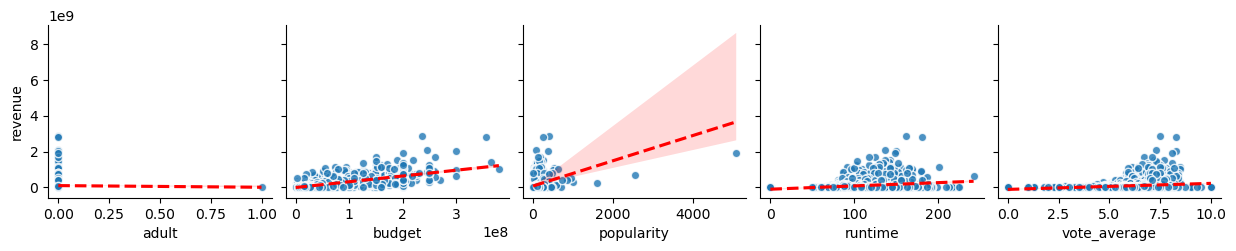

In [26]:
## Making a pairplot with regression lines (first five features)
sns.pairplot(df,y_vars='revenue',kind='reg',x_vars=cols[:5],
             plot_kws=dict(line_kws={'color':'red','ls':'--'},scatter_kws={'edgecolor':'white','lw':1}));

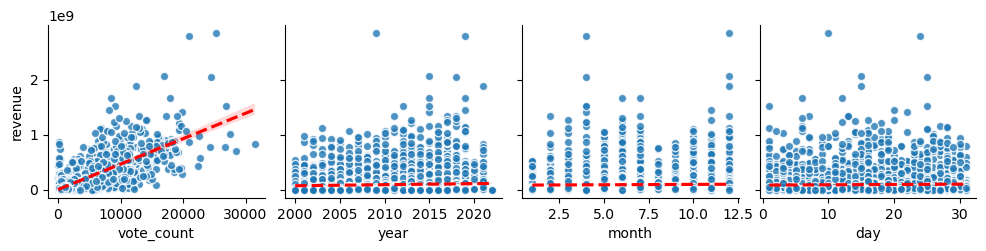

In [27]:
## Making a pairplot with regression lines (next 4 features)
sns.pairplot(df,y_vars='revenue',kind='reg',x_vars=cols[5:],
             plot_kws=dict(line_kws={'color':'red','ls':'--'},scatter_kws={'edgecolor':'white','lw':1}));

In [28]:
## dropping nonlinear features
df= df.drop(columns=['adult','year','month','day'])

In [29]:
## Checking Multicollinearity
corr = df.corr().abs()
corr

/var/folders/50/3xbvh4ss3131ch53yqb8sydr0000gn/T/ipykernel_4597/2666930916.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr().abs()


,belongs_to_collection,budget,popularity,revenue,runtime,vote_average,vote_count,Genre_Comedy,Genre_Music,Genre_Romance,...,Genre_Fantasy,Genre_Horror,Genre_Thriller,Genre_History,Genre_Family,Genre_Mystery,Genre_Western,Genre_War,Genre_TV Movie,Genre_Documentary
belongs_to_collection,1.000000,0.289485,0.178151,0.386398,0.006254,0.053712,0.309483,0.011435,0.029894,0.127830,...,0.130570,0.120561,0.027803,0.085251,0.141739,0.014152,0.016488,0.052764,NaN,0.019688
budget,0.289485,1.000000,0.298774,0.759183,0.215871,0.140851,0.640697,0.045344,0.037264,0.122304,...,0.282590,0.128284,0.022396,0.008416,0.210284,0.034024,0.029263,0.019078,NaN,0.025773
popularity,0.178151,0.298774,1.000000,0.364752,0.076543,0.129881,0.314169,0.033940,0.020038,0.058641,...,0.131501,0.005208,0.014250,0.024375,0.057280,0.010830,0.003326,0.014027,NaN,0.009716
revenue,0.386398,0.759183,0.364752,1.000000,0.206723,0.208700,0.783547,0.026962,0.017153,0.082313,...,0.226236,0.072089,0.049493,0.033439,0.161876,0.036644,0.011232,0.014046,NaN,0.017745
runtime,0.006254,0.215871,0.076543,0.206723,1.000000,0.288563,0.216513,0.219880,0.014723,0.088546,...,0.012660,0.175325,0.000244,0.194491,0.194224,0.005992,0.030627,0.129673,NaN,0.030059
vote_average,0.053712,0.140851,0.129881,0.208700,0.288563,1.000000,0.317474,0.091826,0.052984,0.015449,...,0.036022,0.118128,0.034324,0.109073,0.003643,0.009315,0.018151,0.070221,NaN,0.012990
vote_count,0.309483,0.640697,0.314169,0.783547,0.216513,0.317474,1.000000,0.087823,0.030661,0.095203,...,0.186604,0.032918,0.004387,0.033561,0.054569,0.012126,0.015789,0.015097,NaN,0.020979
Genre_Comedy,0.011435,0.045344,0.033940,0.026962,0.219880,0.091826,0.087823,1.000000,0.038671,0.180097,...,0.012498,0.171623,0.362701,0.142641,0.212593,0.160966,0.032599,0.112442,NaN,0.005214
Genre_Music,0.029894,0.037264,0.020038,0.017153,0.014723,0.052984,0.030661,0.038671,1.000000,0.088956,...,0.010748,0.045721,0.098673,0.012830,0.020628,0.046525,0.016414,0.006804,NaN,0.006309
Genre_Romance,0.127830,0.122304,0.058641,0.082313,0.088546,0.015449,0.095203,0.180097,0.088956,1.000000,...,0.033145,0.147915,0.205423,0.041362,0.085338,0.104283,0.040298,0.021625,NaN,0.017535


None of the feature pairs have correlation outside of the (-0.8,0.8) range. So we keep all of them for now except imdb_id and title (which are essentially keys).

## Running the Model

In [26]:
## Preprocessing
y = df['revenue'].copy()
X = df.drop(columns=['revenue']).copy()
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)
X_train

,adult,belongs_to_collection,budget,popularity,runtime,vote_average,vote_count,certification,Genre_Comedy,Genre_Music,...,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
8296,0.0,True,15000000.0,14.335,95.0,6.9,242.0,PG,False,False,...,False,False,False,False,False,False,False,False,False,False
12356,0.0,False,3000000.0,12.210,92.0,6.2,307.0,R,True,False,...,False,False,False,False,False,False,False,False,False,False
14088,0.0,False,18500000.0,12.889,100.0,6.2,1645.0,PG-13,True,False,...,False,False,False,False,False,False,False,False,True,False
16186,0.0,False,80000000.0,34.021,118.0,6.8,5076.0,R,False,False,...,False,False,False,False,False,False,False,False,False,False
12971,0.0,False,33000000.0,26.790,116.0,8.0,8963.0,R,False,False,...,False,False,False,False,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42885,0.0,False,6900000.0,1.571,99.0,2.5,28.0,NR,False,False,...,False,False,False,False,False,False,False,False,False,False
2896,0.0,False,250000.0,7.630,101.0,5.2,200.0,R,False,False,...,False,False,False,False,False,False,False,False,False,False
24958,0.0,True,75000000.0,77.182,116.0,7.4,13629.0,PG-13,False,False,...,True,False,False,False,False,False,False,False,False,False
33219,0.0,False,108000000.0,53.762,141.0,7.7,16953.0,PG-13,False,False,...,False,False,True,False,False,False,False,False,False,False


In [28]:
## make cat selector and using it to save list of column names
cat_select = make_column_selector(dtype_include='object')
cat_cols = cat_select(X_train)
cat_cols

['certification']

In [29]:
## make num selector and using it to save list of column names
num_select = make_column_selector(dtype_include='number')
num_cols = num_select(X_train)
num_cols

['adult',
 'budget',
 'popularity',
 'runtime',
 'vote_average',
 'vote_count',
 'year',
 'month',
 'day']

In [30]:
## select manually OHE cols for later
bool_select = make_column_selector(dtype_include='bool')
already_ohe_cols = bool_select(X_train)
already_ohe_cols

['belongs_to_collection',
 'Genre_Comedy',
 'Genre_Music',
 'Genre_Romance',
 'Genre_Science Fiction',
 'Genre_Drama',
 'Genre_Action',
 'Genre_Crime',
 'Genre_Adventure',
 'Genre_Animation',
 'Genre_Fantasy',
 'Genre_Horror',
 'Genre_Thriller',
 'Genre_History',
 'Genre_Family',
 'Genre_Mystery',
 'Genre_Western',
 'Genre_War',
 'Genre_TV Movie',
 'Genre_Documentary',
 'ProdComp_20th Century Fox',
 'ProdComp_BBC Films',
 'ProdComp_Blumhouse Productions',
 'ProdComp_CJ Entertainment',
 'ProdComp_Canal+',
 'ProdComp_Ciné+',
 'ProdComp_Columbia Pictures',
 'ProdComp_Dimension Films',
 'ProdComp_DreamWorks Animation',
 'ProdComp_DreamWorks Pictures',
 'ProdComp_Dune Entertainment',
 'ProdComp_Epsilon Motion Pictures',
 'ProdComp_EuropaCorp',
 'ProdComp_Film4 Productions',
 'ProdComp_Focus Features',
 'ProdComp_Fox 2000 Pictures',
 'ProdComp_Fox Searchlight Pictures',
 'ProdComp_France 2 Cinéma',
 'ProdComp_France 3 Cinéma',
 'ProdComp_Ingenious Media',
 'ProdComp_Legendary Pictures',
 'Pr

In [31]:
## convert manual ohe to int
X_train[already_ohe_cols] = X_train[already_ohe_cols].astype(int)
X_test[already_ohe_cols] = X_test[already_ohe_cols].astype(int)

In [32]:
## make pipelines
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                        OneHotEncoder(handle_unknown='ignore',sparse=False)
                        )
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [33]:
preprocessor = make_column_transformer((num_pipe,num_cols),
                                       (cat_pipe,cat_cols),
                                      remainder='passthrough')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [34]:
## fit the col transformer to learn feature names
preprocessor.fit(X_train)

/opt/homebrew/Caskroom/miniforge/base/envs/dojo-env/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


ColumnTransformer(remainder='passthrough',
                  transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 ['adult', 'budget', 'popularity', 'runtime',
                                  'vote_average', 'vote_count', 'year', 'month',
                                  'day']),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['certification'])])

In [35]:
## Using list-slicing to find the encoder 
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)


## Create the empty list
final_features = [*num_cols,*cat_features,*already_ohe_cols]
len(final_features)

85

In [36]:
preprocessor.transform(X_train).shape

(3817, 85)

In [37]:
X_train_tf = pd.DataFrame( preprocessor.transform(X_train), 
                          columns=final_features, index=X_train.index)
X_train_tf

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,...,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
8296,0.0,15000000.0,14.335,95.0,6.9,242.0,2006.0,10.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12356,0.0,3000000.0,12.210,92.0,6.2,307.0,2008.0,9.0,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14088,0.0,18500000.0,12.889,100.0,6.2,1645.0,2009.0,9.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
16186,0.0,80000000.0,34.021,118.0,6.8,5076.0,2010.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12971,0.0,33000000.0,26.790,116.0,8.0,8963.0,2008.0,12.0,9.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42885,0.0,6900000.0,1.571,99.0,2.5,28.0,2017.0,9.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2896,0.0,250000.0,7.630,101.0,5.2,200.0,2002.0,6.0,21.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24958,0.0,75000000.0,77.182,116.0,7.4,13629.0,2013.0,5.0,29.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
33219,0.0,108000000.0,53.762,141.0,7.7,16953.0,2015.0,9.0,30.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
X_test_tf = pd.DataFrame( preprocessor.transform(X_test),
                         columns=final_features, index=X_test.index)
X_test_tf

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,...,ProdComp_Summit Entertainment,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films
3861,0.0,50000000.0,15.914,115.0,6.1,1853.0,2003.0,2.0,6.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
21691,0.0,209000000.0,43.428,131.0,5.8,4636.0,2012.0,4.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3023,0.0,63000000.0,23.415,93.0,6.0,2544.0,2002.0,7.0,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
36313,0.0,3800000.0,8.439,88.0,6.3,225.0,2016.0,8.0,25.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
18964,0.0,90000000.0,97.586,96.0,6.7,5518.0,2011.0,4.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26587,0.0,4000000.0,3.662,77.0,6.2,55.0,2013.0,12.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16240,0.0,170000000.0,67.763,125.0,6.4,6009.0,2010.0,12.0,14.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
16549,0.0,14000000.0,9.241,103.0,5.7,105.0,2010.0,3.0,12.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7993,0.0,150000000.0,31.631,126.0,6.7,5370.0,2006.0,5.0,3.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [39]:
## Make final X_train_df and X_test_df with constants added
X_train_df = sm.add_constant(X_train_tf, prepend=False, has_constant='add')
X_test_df = sm.add_constant(X_test_tf, prepend=False, has_constant='add')
display(X_train_df.head(2),X_test_df.head(2))

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
8296,0.0,15000000.0,14.335,95.0,6.9,242.0,2006.0,10.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12356,0.0,3000000.0,12.210,92.0,6.2,307.0,2008.0,9.0,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,...,ProdComp_TF1 Films Production,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const
3861,0.0,50000000.0,15.914,115.0,6.1,1853.0,2003.0,2.0,6.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
21691,0.0,209000000.0,43.428,131.0,5.8,4636.0,2012.0,4.0,11.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Testing Model Assumptions

In [40]:
## Instantiate an OLS model with the traininig data
model = sm.OLS(y_train,X_train_df)
## Fit the model and view the summary
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     152.9
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:09:40   Log-Likelihood:                -75548.
No. Observations:                3817   AIC:                         1.513e+05
Df Residuals:                    3734   BIC:                         1.518e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
adul

In [41]:
## Get train data performance from sklearn to confirm it matches OLS
y_hat_train = result.predict(X_train_df)
print(f'Training R^2: {r2_score(y_train, y_hat_train):.3f}')

## Get test data performance
y_hat_test = result.predict(X_test_df)
print(f'Testing R^2: {r2_score(y_test, y_hat_test):.3f}')

Training R^2: 0.771
Testing R^2: 0.728


## The Assumptions of Linear Regression
Recall the assumptions are:
- Linearity, i.e. the input features have a linear relationship with the target.
- Little-to-No Multicollinearity i.e. the features are not strongly related to other features.
- Normality, i.e. the model's residuals are approximately normally distributed.
- Homoscedasticity, i.e. he model residuals have equal variance across all predictions.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     152.9
Date:                Mon, 09 Oct 2023   Prob (F-statistic):               0.00
Time:                        20:44:21   Log-Likelihood:                -75548.
No. Observations:                3817   AIC:                         1.513e+05
Df Residuals:                    3734   BIC:                         1.518e+05
Df Model:                          82                                         
Covariance Type:            nonrobust                                         
======================================================================================================
                                         coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
adult                               8.769e+06   9.67e+07      0.091      0.928   -1.81e+08    1.98e+08
budget                                 1.8337      0.060     30.447      0.000       1.716       1.952
popularity                          1.462e+05   1.52e+04      9.611      0.000    1.16e+05    1.76e+05
runtime                              2.74e+05   8.96e+04      3.057      0.002    9.83e+04     4.5e+05
vote_average                       -4.511e+06   1.51e+06     -2.988      0.003   -7.47e+06   -1.55e+06
vote_count                           3.09e+04    693.801     44.542      0.000    2.95e+04    3.23e+04
year                                3.716e+05   3.06e+05      1.216      0.224   -2.28e+05    9.71e+05
month                              -1.632e+05   4.66e+05     -0.350      0.726   -1.08e+06    7.51e+05
day                                -2.388e+04   1.84e+05     -0.130      0.897   -3.84e+05    3.36e+05
certification_G                    -1.078e+08   8.83e+07     -1.221      0.222   -2.81e+08    6.53e+07
certification_NC-17                -1.147e+08    9.2e+07     -1.248      0.212   -2.95e+08    6.56e+07
certification_NR                   -1.001e+08   8.84e+07     -1.133      0.257   -2.73e+08    7.32e+07
certification_PG                   -9.899e+07    8.8e+07     -1.125      0.261   -2.72e+08    7.36e+07
certification_PG-13                -1.115e+08   8.79e+07     -1.269      0.205   -2.84e+08    6.08e+07
certification_R                    -1.281e+08   8.78e+07     -1.458      0.145      -3e+08    4.41e+07
belongs_to_collection               5.298e+07   4.31e+06     12.285      0.000    4.45e+07    6.14e+07
Genre_Comedy                        5.187e+06   4.11e+06      1.263      0.207   -2.87e+06    1.32e+07
Genre_Music                         1.565e+07    9.1e+06      1.718      0.086    -2.2e+06    3.35e+07
Genre_Romance                       5.209e+06   4.55e+06      1.145      0.252   -3.71e+06    1.41e+07
Genre_Science Fiction              -3.582e+07   5.96e+06     -6.011      0.000   -4.75e+07   -2.41e+07
Genre_Drama                          5.09e+05   4.13e+06      0.123      0.902   -7.58e+06     8.6e+06
Genre_Action                       -1.035e+07   4.41e+06     -2.350      0.019    -1.9e+07   -1.71e+06
Genre_Crime                        -8.156e+06   5.06e+06     -1.611      0.107   -1.81e+07    1.77e+06
Genre_Adventure                      5.87e+06   5.25e+06      1.119      0.263   -4.42e+06    1.62e+07
Genre_Animation                     1.726e+07   8.76e+06      1.970      0.049    8.17e+04    3.44e+07
Genre_Fantasy                      -8.385e+06   5.72e+06     -1.466      0.143   -1.96e+07    2.83e+06
Genre_Horror                        5.027e+05    6.1e+06      0.082      0.934   -1.15e+07    1.

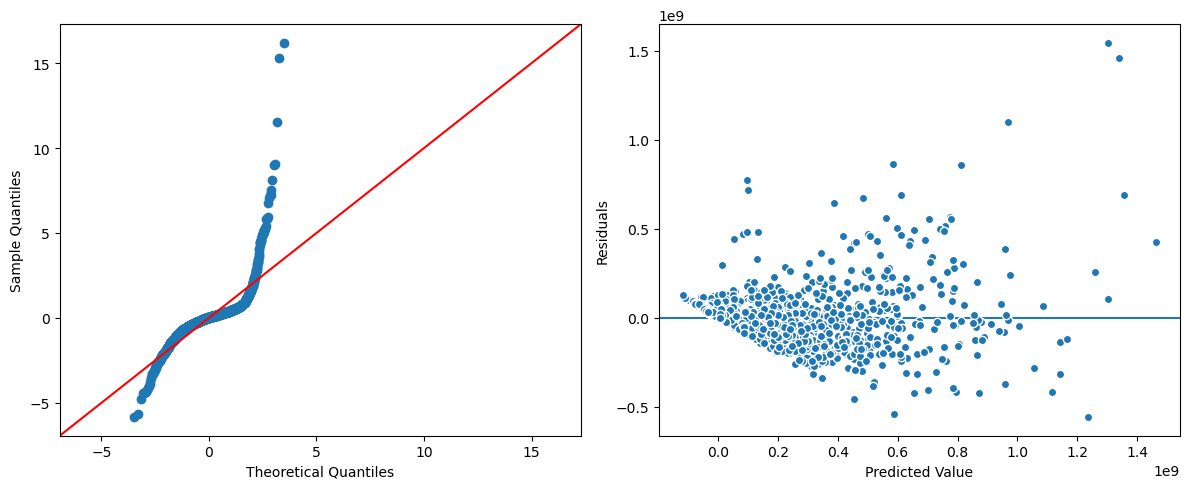

In [42]:
## Evaluate Model
evaluate_ols(result,X_train_df,y_train)

In [43]:
## concatenating training data
Xy_train = pd.concat([X_train_df,y_train],axis=1)
Xy_train

,adult,budget,popularity,runtime,vote_average,vote_count,year,month,day,certification_G,...,ProdComp_TSG Entertainment,ProdComp_The Weinstein Company,ProdComp_Touchstone Pictures,ProdComp_Universal Pictures,ProdComp_Village Roadshow Pictures,ProdComp_Walt Disney Pictures,ProdComp_Warner Bros. Pictures,ProdComp_Working Title Films,const,revenue
8296,0.0,15000000.0,14.335,95.0,6.9,242.0,2006.0,10.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,21000000.0
12356,0.0,3000000.0,12.210,92.0,6.2,307.0,2008.0,9.0,26.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3982459.0
14088,0.0,18500000.0,12.889,100.0,6.2,1645.0,2009.0,9.0,13.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,32406507.0
16186,0.0,80000000.0,34.021,118.0,6.8,5076.0,2010.0,1.0,11.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,157107755.0
12971,0.0,33000000.0,26.790,116.0,8.0,8963.0,2008.0,12.0,9.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,269958228.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42885,0.0,6900000.0,1.571,99.0,2.5,28.0,2017.0,9.0,28.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,5987319.0
2896,0.0,250000.0,7.630,101.0,5.2,200.0,2002.0,6.0,21.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,144008.0
24958,0.0,75000000.0,77.182,116.0,7.4,13629.0,2013.0,5.0,29.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,351723989.0
33219,0.0,108000000.0,53.762,141.0,7.7,16953.0,2015.0,9.0,30.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,630161890.0


In [44]:
## save plot_cols list to show (dropping genre from plot_df from pair_plot)
genre_cols = [c for c in df.columns if c.startswith('Genre')]
plot_cols = Xy_train.drop(columns=['revenue',*genre_cols]).columns

In [45]:
len(plot_cols)

67

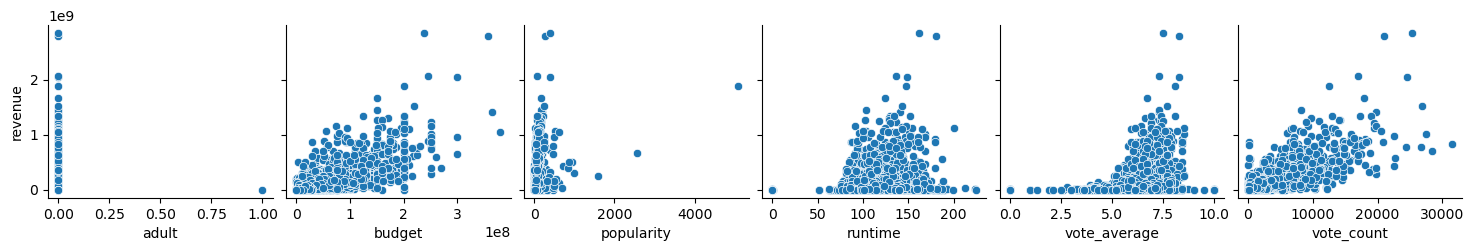

In [46]:
sns.pairplot(data=Xy_train, y_vars='revenue',x_vars=plot_cols[:6])

In [37]:
# Create list of final features
final_features =[]
final_features.extend(num_cols)
cat_features = preprocessor.named_transformers_['pipeline-2'][-1].get_feature_names_out(cat_cols)
final_features.extend(cat_features)

In [38]:
## Transform as dataframes
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns=final_features,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         columns=final_features,
                         index=X_test.index)
X_test_df

ValueError: Shape of passed values is (3817, 3484), indices imply (3817, 3464)

In [ ]:
## Adding constants for statsmodels
X_train_df = sm.add_constant(X_train_df,prepend=False)
X_test_df = sm.add_constant(X_test_df,prepend=False)
X_train_df

## Diagnosing the Model by iteration

In [ ]:
# Removing outliers
scaler = StandardScaler()
z_rev = scaler.fit_transform(y_train.values.reshape(-1,1))
z_rev = 